In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pprint

detector_path = '..'
sys.path.append(detector_path)

from sleep.mass import MASS
from sleep.mass import KEY_EEG, KEY_PAGES, KEY_ID, KEY_MARKS
from sleep.data_ops import seq2inter, inter2seq, seq2inter_with_pages
from evaluation.metrics import by_sample_confusion, by_sample_iou, by_event_confusion, matching

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
dataset = MASS(load_checkpoint=True)

Dataset mass with 14 patients.
Train size: 10. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 19]
Test subjects: 
 [2, 6, 12, 13]
Loading from checkpoint
Loaded


In [4]:
subject_id = 2
page = 11

n2_signal, n2_marks_1 = dataset.get_subject_data(subject_id, which_expert=1)
_, n2_marks_2 = dataset.get_subject_data(subject_id, which_expert=2)
pages = dataset.get_subject_pages(subject_id)

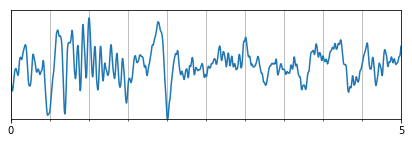

In [5]:
complete_segment = n2_signal[page, :]
short_segment = complete_segment[3000:]
time_axis = np.arange(short_segment.size) / 200

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(time_axis, short_segment)
ax.set_yticks([])
ax.set_xlim([0, 5])
ax.set_ylim([-5, 5])
# ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown), original page %d' % n2_pages[page])
ax.set_xticks([0, 5])
ax.set_xticks(np.arange(0, 5, 0.5), minor=True)
ax.grid(b=True, axis='x', which='minor')

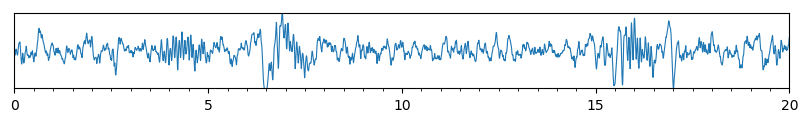

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 1), dpi=100)
time_axis = np.arange(complete_segment.size) / 200
ax.plot(time_axis, complete_segment, linewidth=0.8)
ax.set_yticks([])
ax.set_xlim([0, 20])
ax.set_ylim([-5, 5])
# ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown), original page %d' % n2_pages[page])
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xticks(np.arange(0, 20, 0.5), minor=True)
# ax.grid(b=True, axis='x', which='minor')
plt.show()

In [7]:
import tensorflow as tf
from spectrum.cmorlet import compute_cwt

(1, 500, 32, 1)


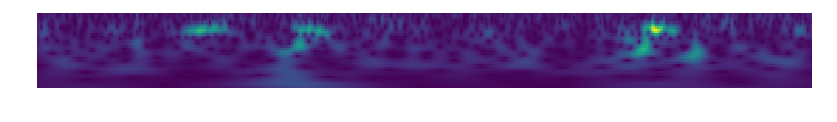

In [8]:
tf.reset_default_graph()
inputs = complete_segment[np.newaxis, :]
outputs = compute_cwt(inputs, [1.5], 200, 1, 30, 32, flattening=True)
outputs = tf.layers.average_pooling2d(inputs=outputs, pool_size=(8, 1), strides=(8, 1))
# outputs = tf.log(outputs + 1e-3)

with tf.Session() as sess:
    my_cwt = sess.run(outputs)
print(my_cwt.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 1), dpi=100)
my_cwt_image = np.transpose(my_cwt[0, :, :, 0], (1, 0))
ax.imshow(my_cwt_image, interpolation=None, aspect='auto', extent=[0, 20, 32, 1])
ax.axis('off')
# ax.set_title('CWT CMorlet, [3, 40] Hz, Fb = 1.5')
plt.show()

In [9]:
# Generate initial and last scale
fs = 200
s_0 = fs / 30
s_n = fs / 1
n_scales = 32

# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))

# Generate the frequency range
frequencies = fs / scales
print(frequencies)

[30.         26.88265645 24.0892406  21.58609264 19.34305042 17.33308597
 15.53197985 13.91802927 12.47178665 11.17582519 10.01452897  8.97390473
  8.04141326  7.20581834  6.45705129  5.78608972  5.18484874  4.64608358
  4.16330229  3.73068751  3.34302635  2.99564763  2.68436554  2.40542922
  2.15547758  1.93149877  1.73079393  1.55094462  1.38978371  1.24536927
  1.11596114  1.        ]


In [10]:
lims = [0, 3.5, 7.5, 13, 31]
n_bands = len(lims)-1
for i in range(n_bands):
    n_freqs = np.where((frequencies >= lims[i]) & (frequencies <= lims[i+1]))[0].size
    print(n_freqs, lims[i], lims[i+1])

    #delta < 4
#theta 3.5-7.5
#alpha 7.5-13
#beta 13-31

12 0 3.5
7 3.5 7.5
5 7.5 13
8 13 31


(1, 4000)


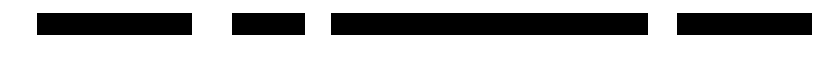

In [11]:
my_marks = n2_marks_1[page, :]
my_marks = my_marks[np.newaxis, :]
print(my_marks.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 0.3), dpi=100)
ax.imshow(my_marks, interpolation=None, aspect='auto', extent=[0, 20, 32, 1], cmap='gray')
ax.axis('off')
# ax.set_title('CWT CMorlet, [3, 40] Hz, Fb = 1.5')
plt.show()

In [12]:
# predictions_ppt3_path = '/home/ntapia/Projects/local-only/spindle-pesos-ppt3-sept2018'
predictions_ppt3_path = '../results/falcondata/marks_ppt3'
# predictions_ppt3_path = '../results/predictions/bsf_20190106/version_v2_typebn_bn_try_4'
print(os.listdir(predictions_ppt3_path))

test_preds = np.loadtxt(os.path.join(predictions_ppt3_path, 'predictions_test_central.csv'))
test_expert = np.loadtxt(os.path.join(predictions_ppt3_path, 'expert1_test.csv'))

['expert1_val.csv', 'predictions_val_central.csv', 'predictions_test_right.csv', 'expert1_test.csv', 'predictions_test_left.csv', 'reg_ids', 'predictions_val.csv', 'predictions_val_left.csv', 'predictions_val_right.csv', 'predictions_test_central.csv']


In [13]:
test_preds.shape

(3094, 400)

In [14]:
test_expert.shape

(3094, 400)

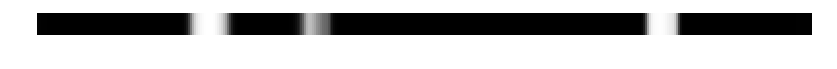

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 0.3), dpi=100)
ax.imshow(test_preds[page, :][np.newaxis, :], interpolation=None, aspect='auto', extent=[0, 20, 32, 1], cmap='gray')
ax.axis('off')
# ax.set_title('CWT CMorlet, [3, 40] Hz, Fb = 1.5')
plt.show()

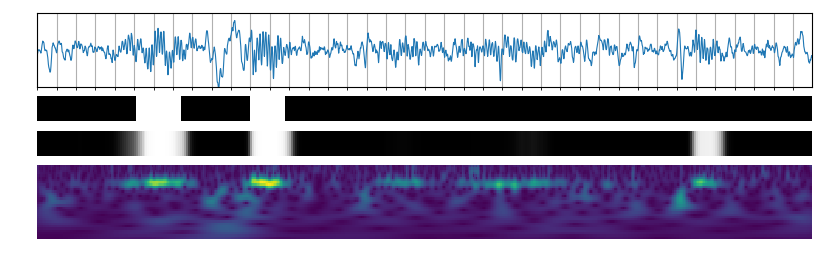

In [17]:
# --- Particular result

# candidates = 13  uno bueno uno muy baja deteccion
# 15: muchas buenas
# 24: uno se lo perdio y dos buenos
# 29: se perdio uno dificil y corto
# 31: varios buenos
# 118: FP
# 410: FP que quizas no es FP
# 480: FP que quizas no es FP


subject_id = 2
page = 480
fs = 200
start_time = 0
end_time = 20

n2_signal, n2_marks_1 = dataset.get_subject_data(subject_id, which_expert=1)
_, n2_marks_2 = dataset.get_subject_data(subject_id, which_expert=2)
pages = dataset.get_subject_pages(subject_id)

complete_segment = n2_signal[page, :]
time_axis = np.arange(complete_segment.size) / fs


fig = plt.figure(figsize=(10, 3), dpi=100) 
gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 1, 3])

# fig, ax = plt.subplots(1, 1, figsize=(10, 1), dpi=100)
time_axis = np.arange(complete_segment.size) / fs
ax = fig.add_subplot(gs[0])
ax.plot(time_axis, complete_segment, linewidth=0.8)
ax.set_yticks([])
ax.set_xlim([start_time, end_time])
ax.set_ylim([-5, 5])
# ax0.set_title('EEG Signal, C3-CLE (intervals of 0.5s are shown), original page %d' % n2_pages[page])
ax.set_xticks([])
ax.set_xticks(np.arange(start_time, end_time, 0.5), minor=True)
ax.grid(b=True, axis='x', which='minor')
# plt.show()

start_sample = int(start_time*(fs))
end_sample = int(end_time*(fs))

#fig, ax = plt.subplots(1, 1, figsize=(10, 0.3), dpi=100)
ax = fig.add_subplot(gs[1])
ax.imshow(n2_marks_1[page, start_sample:end_sample][np.newaxis, :], interpolation=None, aspect='auto', extent=[0, 20, 32, 1], cmap='gray')
ax.axis('off')
# plt.show()

start_sample = int(start_time*(fs/10))
end_sample = int(end_time*(fs/10))

#fig, ax = plt.subplots(1, 1, figsize=(10, 0.3), dpi=100)
ax = fig.add_subplot(gs[2])
ax.imshow(test_preds[page, start_sample:end_sample][np.newaxis, :], interpolation=None, aspect='auto', extent=[0, 20, 32, 1], cmap='gray')
ax.axis('off')
# plt.show()
#print(test_preds[page, start_sample:end_sample])

tf.reset_default_graph()
inputs = complete_segment[np.newaxis, :]
outputs = compute_cwt(inputs, [1.5], 200, 1, 30, 32, flattening=True)
outputs = tf.layers.average_pooling2d(inputs=outputs, pool_size=(8, 1), strides=(8, 1))
# outputs = tf.log(outputs + 1e-3)

with tf.Session() as sess:
    my_cwt = sess.run(outputs)
# print(my_cwt.shape)

# fig, ax = plt.subplots(1, 1, figsize=(10, 1), dpi=100)
ax = fig.add_subplot(gs[3])
my_cwt_image = np.transpose(my_cwt[0, :, :, 0], (1, 0))
ax.imshow(my_cwt_image, interpolation=None, aspect='auto', extent=[0, 20, 32, 1])
ax.axis('off')
# ax.set_title('CWT CMorlet, [3, 40] Hz, Fb = 1.5')
plt.show()